In [35]:
import pandas as pd
import numpy as np
import re, reprlib, sys

%load_ext cython
%load_ext cythonmagic
%matplotlib inline
import matplotlib.pyplot as plt
from pandas_confusion import ConfusionMatrix

import nltk as n
import nltk, nltk.classify.util, nltk.metrics, nltk.tokenize, nltk.stem
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.classify import MaxentClassifier
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures as BAM
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.tag.sequential import ClassifierBasedPOSTagger

from itertools import chain

import sklearn as sk
from sklearn import cross_validation
from sklearn.feature_extraction.text import *
from sklearn.svm import *
from sklearn.pipeline import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *

# n.download()

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The cythonmagic extension is already loaded. To reload it, use:
  %reload_ext cythonmagic


### Read data and show them

In [3]:
data = pd.read_csv("data.csv", parse_dates=True, infer_datetime_format=True, 
            sep = None, encoding = "latin-1", engine = "python")
data.head(n=2)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,180,14861.6,93.29,0.03,15661,0.49,0.1
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,2.65,3,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,180,14861.6,93.29,0.03,15661,0.49,0.1


In [49]:
d = {'n': "no", 'y': "yes"}

# http://stackoverflow.com/a/17702781
data = data.replace(d)

neu = data[["#AUTHID","STATUS","cNEU"]]
ext = data[["#AUTHID","STATUS","cEXT"]]
agr = data[["#AUTHID","STATUS","cAGR"]]
con = data[["#AUTHID","STATUS","cCON"]]
opn = data[["#AUTHID","STATUS","cOPN"]]

In [5]:
# data.describe()

In [50]:
# plit data
train_neu, test_neu = sk.cross_validation.train_test_split(neu, train_size = 0.66)
train_ext, test_ext = sk.cross_validation.train_test_split(ext, train_size = 0.66)
train_agr, test_agr = sk.cross_validation.train_test_split(agr, train_size = 0.66)
train_con, test_con = sk.cross_validation.train_test_split(con, train_size = 0.66)
train_opn, test_opn = sk.cross_validation.train_test_split(opn, train_size = 0.66)
print(len(train_neu))

# http://billchambers.me/tutorials/2015/01/14/python-nlp-cheatsheet-nltk-scikit-learn.html
# http://glowingpython.blogspot.de/2013/07/combining-scikit-learn-and-ntlk.html
# http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
# https://stackoverflow.com/questions/10526579/use-scikit-learn-to-classify-into-multiple-categories
# https://github.com/anuraagvak/IRE-PersonalityRecognition-Final/blob/master/ire_report.pdf
# https://github.com/Charudatt89/Personality_Recognition/blob/master/22-9-PersonalityRecognition/Report/Report.pdf

6545


In [47]:
target_names = ['yes', 'no']

classifier = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC()))])


clas_fit = classifier.fit(train_neu["STATUS"], train_neu["cNEU"])
predicted = classifier.predict(test_neu["cNEU"])

print(cross_validation.cross_val_score(classifier, test_neu["STATUS"], predicted))

print(predicted)

count = 0
for item, labels in zip(test_neu["STATUS"], predicted):
    count += 1
print(count)

[ 0.592       0.57384342  0.58860196]
['yes' 'no' 'yes' ..., 'no' 'yes' 'no']
3372


Confusion Matrix:

Predicted   no  yes  __all__
Actual                      
no         389  214      603
yes        317  208      525
__all__    706  422     1128


Overall Statistics:

Accuracy: 0.529255319149
95% CI: (0.49963934814802252, 0.55871834870459092)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.999999999985
Kappa: 0.0418290365308
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                       no        yes
Population                                  1128       1128
P: Condition positive                        603        525
N: Condition negative                        525        603
Test outcome positive                        706        422
Test outcome negative                        422        706
TP: True Positive                            389        208
TN: True Negative                            208        389
FP: False Positive                           317        214
FN: False Negative                           214        317
TP

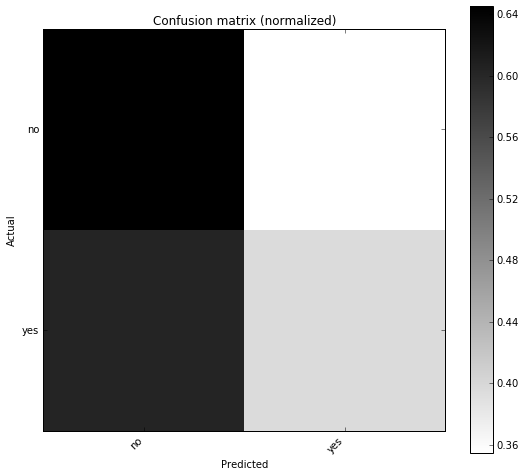

In [48]:
confusion_matrix = ConfusionMatrix(test_neu["cNEU"], predicted)
confusion_matrix.print_stats()

confusion_matrix.plot(normalized=True)

<strong>Rules</strong>
    * Each single sentence counts (but no weird symbols incl. punc.) and lowercase
    * We do use lemmalization, deleting words etc.
    
##### Meeting with Dustin:    
    * Split dataset according to traits, with one column status and another one the yes/no variable

In [36]:
#tagger = n.ClassifierBasedPOSTagger(train=train_neu)


In [5]:
lines_of_trained_dataset = train["STATUS"].str.lower()
lines_of_trained_dataset.to_csv("train.csv")
# print(lines_of_combined_dataset.head(n=5))

In [6]:
# http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize
twt = n.TreebankWordTokenizer()

# Create lists
list_of_rows_CD = [l.split("\n")[0] for l in lines_of_trained_dataset]

list_of_splitted_words_CD, list_of_sentences = [], []

for k in list_of_rows_CD:
    list_of_sentences.append(n.sent_tokenize(k))
    
for kCD in list_of_rows_CD:
    list_of_splitted_words_CD.append(n.word_tokenize(kCD))

In [7]:
print(list_of_splitted_words_CD[:2], "\n\n", list_of_rows_CD[:2], "\n\n", list_of_sentences[:2])

[['will', 'try', 'my', 'hands', 'at', 'sushi', 'makin', "'", ':', 'p'], ['whilst', 'i', 'may', 'not', 'understand', 'the', 'history', 'behind', 'thanksgiving', ',', 'i', 'can', 'get', 'behind', 'any', 'holiday', 'that', 'consists', 'of', 'a', 'huge', 'amount', 'of', 'food', ',', 'alcohol', 'and', 'friends', '.', 'happy', 'thanksgiving', 'to', 'my', 'american', 'friends', '.', 'and', 'to', 'anyone', 'else', ',', 'today', 'is', 'just', 'an', 'excuse', 'for', 'us', 'to', 'take', 'part', 'in', '``', 'cultural', 'diversity', "''", 'and', 'get', 'drunk', 'and', 'stuffed', 'with', 'lots', 'of', 'food', '.']] 

 ["will try my hands at sushi makin' :p", 'whilst i may not understand the history behind thanksgiving, i can get behind any holiday that consists of a huge amount of food, alcohol and friends. happy thanksgiving to my american friends. and to anyone else, today is just an excuse for us to take part in "cultural diversity" and get drunk and stuffed with lots of food.'] 

 [["will try my

In [8]:
# https://stackoverflow.com/questions/2058985/python-count-sub-lists-in-nested-list
print("there are", sum(len(x) for x in list_of_splitted_words_CD), "tokens in", len(list_of_sentences), "sentences")

there are 116764 tokens in 6545 sentences


In [9]:
#print(list_of_rows_CD[:2], "\n")
#print(list_of_sentences[:2],"\n") 
#print(list_of_splitted_words_CD[:2], "\n")

### Different tokenizers (will decide later on which one)

Source: http://text-processing.com/demo/tokenize/


<!-- <img src="dif_tokenizers.png"> -->

### SnowballStemmer 

##### https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg

> Stemming is a technique to remove affixes from a word, ending up with the stem. For
example, the stem of cooking is cook, and a good stemming algorithm knows that the ing
suffix can be removed.


### Lemmatization 
is very similar to stemming, but is more akin to synonym replacement. A lemma is a root word, as opposed to the root stem. So unlike stemming, you are always left with a valid word that means the same thing. However, the word you end up with can be completely different.

In [10]:
# Huge nested lists
# http://www.nltk.org/api/nltk.stem.html#module-nltk.stem.wordnet

nest_list_lm = [[] for _ in range(len(list_of_splitted_words_CD))]

lm = n.stem.WordNetLemmatizer()

for sentence in list_of_splitted_words_CD: 
    for word in sentence:
        nest_list_lm[list_of_splitted_words_CD.index(sentence)].append(lm.lemmatize(word))

print("Original \n", reprlib.repr(list_of_sentences), "\n")
print("Lemmatizer \n", reprlib.repr(nest_list_lm), "\n")

Original 
 [["will try my ...shi makin' :p"], ['whilst i may... and friends.', 'happy thanks...ican friends.', 'and to anyon...lots of food.'], ['wants to kno...stume off him'], ['is stoked th... - in denver!', 'ah...memorie... cambridge...'], ['just watched...o have talent'], ['ewww 33" of ...e since 1969!'], ...] 

Lemmatizer 
 [['will', 'try', 'my', 'hand', 'at', 'sushi', ...], ['whilst', 'i', 'may', 'not', 'understand', 'the', ...], ['want', 'to', 'know', 'if', 'anyone', 'ha', ...], ['is', 'stoked', 'that', 'she', 'is', 'going', ...], ['just', 'watched', 'the', '*propname*', 'press', 'conference', ...], ['ewww', '33', "''", 'of', 'snow', '...', ...], ...] 



### Removing repeating characters

In [11]:
# book 38
class RepeatReplacer(object):
    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'
        
    def replace(self, word):        
        if wordnet.synsets(word):
            return word
    
        repl_word = self.repeat_regexp.sub(self.repl, word)

        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word
        
    def delete_stupid_chars(self, word):
        """
        http://stackoverflow.com/a/3874768
        used above
        replaced_word = self.replace(word)
        """
        rem = "!?#.,();:'[].,//``...~<>$%^&*-_-=+"
        return word.translate(str.maketrans(dict.fromkeys(rem)))

replacer = RepeatReplacer()
replacer.delete_stupid_chars("!?sdf,word!??)()")

'sdfword'

In [12]:
def delete_repChars():
    nest_list_lm_repchars = [[] for _ in range(len(nest_list_lm))]
    for sentence in nest_list_lm:
        for word in sentence:
            nest_list_lm_repchars[nest_list_lm.index(sentence)].append(replacer.delete_stupid_chars(word))
    return nest_list_lm_repchars

def delete_empty_strings():
    nest = [[] for _ in range(len(nest_list_lm_repchars))]
    for sentence in nest_list_lm_repchars: 
        for word in sentence:
            if word != '':
                nest[nest_list_lm_repchars.index(sentence)].append(word)
    return nest

nest_list_lm_repchars = delete_repChars()
nest = delete_empty_strings()

In [13]:
outlst = [' '.join([str(c) for c in hm]) for hm in nest]

print(reprlib.repr(nest_list_lm_repchars), "\n\n", reprlib.repr(outlst), "\n\n", reprlib.repr(nest))

[['will', 'try', 'my', 'hand', 'at', 'sushi', ...], ['whilst', 'i', 'may', 'not', 'understand', 'the', ...], ['want', 'to', 'know', 'if', 'anyone', 'ha', ...], ['is', 'stoked', 'that', 'she', 'is', 'going', ...], ['just', 'watched', 'the', 'propname', 'press', 'conference', ...], ['ewww', '33', '', 'of', 'snow', '', ...], ...] 

 ['will try my ...sushi makin p', 'whilst i may...h lot of food', 'want to know...stume off him', 'is stoked th... in cambridge', 'just watched...o have talent', 'ewww 33 of s...me since 1969', ...] 

 [['will', 'try', 'my', 'hand', 'at', 'sushi', ...], ['whilst', 'i', 'may', 'not', 'understand', 'the', ...], ['want', 'to', 'know', 'if', 'anyone', 'ha', ...], ['is', 'stoked', 'that', 'she', 'is', 'going', ...], ['just', 'watched', 'the', 'propname', 'press', 'conference', ...], ['ewww', '33', 'of', 'snow', 'apparently', 'the', ...], ...]


In [14]:
#http://aylien.com/web-summit-2015-tweets-part1
vectorizer = TfidfVectorizer(min_df=4, max_features = 10000)
vz = vectorizer.fit_transform(outlst)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

print("devil: " + str(tfidf["devil"]))

devil: 7.2216600976


In [33]:
from nltk.corpus import PlaintextCorpusReader
import os
os.chdir("/home/jm/Documents/python-notebook/")
newcorpus = PlaintextCorpusReader("./", '.*\.txt')
print(type(newcorpus))

#os.chdir("/home/jm/Documents/nltk-trainer")
print(os.getcwd())
%run train_tagger.py newcorpus --fraction 0.75


<class 'nltk.corpus.reader.plaintext.PlaintextCorpusReader'>
/home/jm/Documents/python-notebook


ERROR: File `'train_tagger.py'` not found.


In [16]:
from nltk.corpus import treebank, brown
from nltk.tag import *
from nltk.tag.util import *

# backoff = DefaultTagger('NN')
# tagger = BackoffTagger([UnigramTagger, BigramTagger,TrigramTagger])
# print(brown.sents(categories='news')[0])
# print(brown.tagged_sents(categories='news')[0])

# tagger1 = DefaultTagger('NN')
# t1 = tagger1.tag_sents(nest)
# print(t1[0])

# bitagger = BigramTagger(t1)
# tritagger = TrigramTagger(train_sents)

train_sents =  treebank.tagged_sents()[3000:]
test_sents =  treebank.tagged_sents()[:3000]

#print(test_sents[0])
tagger = n.ClassifierBasedPOSTagger(train=train_sents)
tagger.evaluate(test_sents)

0.8860677839274426

### Create tagged words from all sentences

In [17]:
#print(reprlib.repr(nest_list_without_stopwords_lm))

print(list_of_rows_CD[0])
print(list_of_splitted_words_CD[0])
print(list_of_sentences[0], "\n")

#tag_words = n.pos_tag(list_of_splitted_words_CD)
#print(tag_words, "\n")
# print(reprlib.repr(tagged_words()))


will try my hands at sushi makin' :p
['will', 'try', 'my', 'hands', 'at', 'sushi', 'makin', "'", ':', 'p']
["will try my hands at sushi makin' :p"] 



In [18]:
nest_list_tagged_words = [[] for _ in range(len(nest_list_without_stopwords_lm_repchars))]

#def tagged_words():
#    for sentence in nest_list_without_stopwords_lm_repchars:
#        for words in sentence:
#            nest_list_tagged_words[nest_list_without_stopwords_lm_repchars.index(sentence)].append(n.pos_tag(words))
#    return nest_list_tagged_words


NameError: name 'nest_list_without_stopwords_lm_repchars' is not defined

### Unigram features

Use -a for code analysis

In [19]:
def word_fea(words):
    return dict((word, True))
word_fea(outlst)

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [20]:
# Bigram collocation
# https://github.com/neotenic/cancer/blob/master/nltk.ipynb
def bigram_features(words, score_fn=BAM.chi_sq): 
    bg_finder = BigramCollocationFinder.from_words(words) 
    bigrams = bg_finder.nbest(score_fn, 100000) 
    return dict((bg, True) for bg in chain(words, bigrams)) 

#bigram_features(outlst, score_fn=BAM.chi_sq)

In [21]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC()))])

In [22]:
cl = n.NaiveBayesClassifier.train(train)
print(n.classify.accuracy(cl, test),"%.3f")
cl.show_most_informative_features(40)
cl.prob_classify(featurize(name)) #

ValueError: too many values to unpack (expected 2)